<a href="https://colab.research.google.com/github/Benjamin-morel/TensorFlow/blob/main/02_%5BNLP%5D_classification_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---


# **Machine Learning Model: basic text classification**

| | |
|------|------|
| Filename | 02_[NLP]_classification_test.ipynb |
| Author(s) | Benjamin (contact.upside830@silomails.com) |
| Date | September 4, 2024 |
| Aim(s) | Build, train and evaluate a neural network machine learning model that classifies movie reviews as positives or negatives. |
| Dataset(s) | IMDb Movie Reviews dataset [[1]](https://aclanthology.org/P11-1015.pdf)|
| Version | Python 3.10.12 - TensorFlow 2.17.1 - final notebook version |


<br> **!!Read before running!!** <br>
* **Step 1.** Fill in the inputs.
* **Step 2.** GPU execution is recommended for training. Yet, a pre-trained model can be used by running this notebook on a CPU. Using a pre-trained model saves time, computer resources and CO2 emissions.
* **Step 3.** Run all and read comments.
---

#### **Motivation**

The IMDb Movie Reviews database - composed of over 50,000 movie reviews on internet - is used to built a binary classification model. In the last section, weights of the neural network are used to make correspondences and analogies between words.

#### **Outline**
* Input section
* Python libraries & display
* Data retrieval and pre-processing
* Model and training
* Evaluation and limitations
* Go further: the embedding dictionary
* Limitations and conclusion
* References

---



## **0. Input section**

In [ ]:
max_features = 5000 # size of the dictionary (see section 2.3)
max_length = 500 # truncate to the 500th word (see section 2.3)
epochs = 100 # number of epoch for training (see section 3.3)

---

## **1. Python libraries & display utilities**



In [ ]:
# @title 1.1. Python libraries [RUN ME]

"""math"""
import numpy as np # linear algebra
import sklearn.metrics # scores and evaluation metrics

"""file opening and pre-processing"""
from os import path, listdir # miscellaneous operating system interfaces
from re import escape # regular expressions
from shutil import rmtree # operations on files
from string import punctuation # string manipulation

"""ML models"""
import tensorflow as tf # framework for ML/DL
from tensorflow import keras # API used to build model in TensorFlow

"""display and export"""
from PIL import Image # image processing capabilities
import matplotlib.pyplot as plt # graphing package
import json # for data exchange format

"""performances"""
from time import time # timer
start = time()
device = tf.config.list_physical_devices(device_type=None)[-1][-1]

In [ ]:
# @title 1.2. Import Github files [RUN ME]

"""clone the Github repertory TensorFlow and import files (see section 3.3)"""
def get_github_files():
  !git clone https://github.com/Benjamin-morel/TensorFlow.git TensorFlow_duplicata
  path_training_curve = 'TensorFlow_duplicata/99_pre_trained_models/02_classification_text/results_graph.png'
  path_model = 'TensorFlow_duplicata/99_pre_trained_models/02_classification_text/02_classification_text.keras'
  training_curves = Image.open(path_training_curve)
  model = keras.models.load_model(path_model, custom_objects={'custom_standardization': custom_standardization})
  !rm -rf TensorFlow_duplicata/
  return training_curves, model

In [ ]:
# @title 1.3. Figure plots [RUN ME]

"""write a random movie review (see section 2.2)"""
def plot_text(batch):
  for text, label in batch:
      if label.numpy()[0] == 0: print("Here's an extract from a negative review: \n", text.numpy()[0])
      else: print("Here's an extract from a positive review: \n", text.numpy()[0])

"""plot distribution of dataset labels (see section 2.2)"""
def plot_distribution(dataset):
  labels = tf.concat([y for x, y in dataset], axis=0) # collect dataset labels only
  plt.hist(labels, bins=[-0.4,0.4, 0.6, 1.4], range=[0,1], align='mid')
  plt.xlabel("Sentiment"), plt.ylabel("Total reviews"), plt.title("Dataset label distribution"), plt.xticks([0,1], ["Negative", "Positive"])
  plt.show()

"""plot text number Vs. word number graph  (see section 2.2)"""
def plot_distribution_word(dataset):
  texts, nb_word = [], []

  for text, label in dataset.take(int(tf.data.experimental.cardinality(raw_test_ds))):
      for i in range(len(text)):
          texts.append(text.numpy()[i])
          nb_word.append(len(text.numpy()[i].split())) # count the number of words

  fig = plt.figure(figsize=(7,5))
  plt.hist(nb_word, bins=max(nb_word))
  plt.plot([np.mean(nb_word), np.mean(nb_word)], [0,150], label="mean")
  plt.plot([np.median(nb_word), np.median(nb_word)], [0,150], label="median")
  plt.plot([np.percentile(nb_word, 90), np.percentile(nb_word, 90)], [0,150], label="90th percentile")
  plt.xlim([0, 1000]), plt.xticks(range(0,1100, 100)), plt.xlabel("# of words"), plt.ylabel("# of texts")
  plt.title("Number of text Vs. number of words")
  plt.legend()
  plt.show()

"""plot training curves (see section 3.3)"""
def plot_evolution(history):
  loss_train, loss_val = history[0], history[2]
  acc_train, acc_val = history[1], history[3]
  epochs = range(1, len(acc_train) + 1)

  plt.subplot(2,1,1, xlabel='epoch', ylabel='loss')
  plt.plot(epochs, loss_train, label='Training', color='blue')
  plt.plot(epochs, loss_val, label='Validation', color='orange')
  plt.legend(loc='best', fontsize=10)
  plt.grid(True, linestyle='--', alpha=0.6)

  plt.subplot(2,1,2, xlabel='epoch', ylabel='accuracy')
  plt.plot(epochs, acc_train, color='blue')
  plt.plot(epochs, acc_val, color='orange')
  plt.grid(True, linestyle='--', alpha=0.6)
  plt.show()

"""plot evaluation graphs (see section 4.1)"""
def plot_evaluation(test_dataset, predictions, labels=[0,1]):
  actuals = tf.concat([y for x, y in test_dataset], axis=0)
  predicted_labels = np.round(predictions, 0)

  plt.figure(figsize=(12,5))

  confusion_mat = tf.math.confusion_matrix(actuals,predicted_labels) # columns = prediction labels / rows = real labels

  # Subplot 1: Confusion matrix
  plt.subplot(1,2,1, xlabel="Predictions", ylabel="Actuals", title="Confusion matrix of the test set", xticks=[0,1], yticks=[0,1])
  plt.imshow(confusion_mat)

  for i in range(confusion_mat.shape[0]): # annotation in each cnfusion matrix cell
      for j in range(confusion_mat.shape[1]):
          plt.text(x=j, y=i,s=int(confusion_mat[i, j]), va='center', ha='center', size='large')

  # Subplot 2: ROC curve
  fpr, tpr, _ = sklearn.metrics.roc_curve(actuals,  predictions.ravel())
  plt.subplot(1,2,2, xlabel="FPR", ylabel="TPR", title="ROC curve")
  plt.plot(fpr, tpr)

  # Metrics info
  accuracy = sklearn.metrics.accuracy_score(actuals, predicted_labels)
  recall = sklearn.metrics.recall_score(actuals, predicted_labels)
  F1_score = sklearn.metrics.f1_score(actuals, predicted_labels)

  print("############################")
  print("Evaluation on the test set: ")
  print("############################")
  print("Accuracy...{:.4f}" .format(accuracy))
  print("Recall.....{:.4f}" .format(recall))
  print("F1-score...{:.4f}" .format(F1_score))

  plt.show()

"""plot the distribution of text number Vs. predicted score (see section 4.3)"""
def plot_predicted_score(predictions, max_length):
  plt.figure(figsize=(5,5))
  plt.subplot(2,1,1, title=("max token = %d" %max_length), ylabel='# of text', ylim=[0, 7000])
  plt.hist(predictions, bins=50, cumulative=False)
  plt.subplot(2,1,2, xlabel="Model score", ylabel="# of text", ylim=[0,26000])
  plt.hist(predictions, bins=50, cumulative=True)
  plt.show()

"""plot the error rate Vs. word count  (see section 4.3)"""
def plot_error_rate(unique_elements_error, ratio, max_length):
  plt.figure(figsize=(7,5))
  plt.hist(unique_elements_error, weights=100*ratio, bins=max(unique_elements_error), cumulative=False)
  plt.xlim([0, 1100]), plt.xticks(range(0,1200, 400)), plt.xlabel("# of words in the text"), plt.ylabel("Prediction error [%]"), plt.ylim([0, 110])
  plt.title("max token = %d" %max_length)
  plt.show()

---


## **2. Data retrieval and pre-processing**

### 2.1. IMDb Movie Dataset

The IMDb Movie Reviews is a database created for sentiment analysis in movie reviews. It contains 50,000 movie reviews labeled with sentiment (1 for positive and 0 for negative). The database is extracted and placed in the folder `review_dataset`. The architecture of `review_dataset` is as follows:

```markdown
**review_dataset/**
. . . aclImdb/
. . . . . . train/
. . . . . . . . . pos/
. . . . . . . . . . . . *labeledBow.feat*
. . . . . . . . . . . . *pos_review_1.txt*
. . . . . . . . . . . . *pos_review_2.txt*
. . . . . . . . . . . . [...]
. . . . . . . . . neg/
. . . . . . . . . . . . *labeledBow.feat*
. . . . . . . . . . . . *neg_review_1.txt*
. . . . . . . . . . . . [...]
. . . . . . . . . unsup/
. . . . . . . . . . . . *unsup_review_1.txt*
. . . . . . . . . . . . [...]
. . . . . . test/
. . . . . . . . . pos/
. . . . . . . . . . . . *labeledBow.feat*
. . . . . . . . . . . . *pos_review_1.txt*
. . . . . . . . . . . . [...]
. . . . . . . . . neg/
. . . . . . . . . . . . [...]
. . . . . . *README*
. . . . . . *imdb.vocab*
. . . . . . *imdbEr.text*
```

Reviews with a score of 7/10 or higher are considered positive (label = 1) and reviews with a score of 4/10 or lower are considered negative (label = 0). Scores and labels are contained in the files `labeledBow.feat`.

The subfolder `unsup` contains unlabeled reviews and is deleted since it has no interest to the model.

Other files are included in the folder like `README` which provides information about the dataset and how to use it. Files `imdb.vocab` and `imdbEr.txt` contain additional information about errors, URL website and specific annotations.


In [ ]:
"""retrieve data"""
def get_data(url, batch_size, validation_ratio):
  folder_name = 'review_dataset'
  data_dir = keras.utils.get_file(folder_name, url, untar=True)
  data_dir = path.join(data_dir, 'aclImdb')
  train_dir = path.join(data_dir, 'train')
  remove_dir = path.join(train_dir, 'unsup') # remove the folder with unlabeled reviews for unsupervised learning
  rmtree(remove_dir)
  test_dir = path.join(data_dir, 'test')

  train_ds = keras.utils.text_dataset_from_directory(train_dir, batch_size=batch_size, validation_split=0.2, subset='training', shuffle=True, seed=1)
  val_ds = keras.utils.text_dataset_from_directory(train_dir, batch_size=batch_size, validation_split=0.2, subset='validation', shuffle=True, seed=1)
  test_ds = keras.utils.text_dataset_from_directory(test_dir, batch_size=batch_size)
  return train_ds, val_ds, test_ds

Movie reviews are divided into 3 splits: `train`, `test` and `validation`. Only the validation set is not available into `aclImdb` and so it is created by using 20% of the training dataset.

These datasets are randomly shuffled and then batches with the API `utils. Datasets`. Tensors are stored in the data structures `tf.data.Dataset`, a specific type of data structure in which batches are not loaded into the immediate memory but only when they are called up.

In [ ]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

raw_train_ds, raw_val_ds, raw_test_ds = get_data(url, 32, 0.2)

84125825/84125825 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step
Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


### 2.2. IMDb dataset analysis

In [ ]:
plot_text(raw_train_ds.take(1)) # show an example of movie review from the first training set batch

Here's an extract from a negative review: 
 b'Stupid and just plain weird movie about some kid who becomes traumatized when he finds out Santa isn\'t real (???). He grows up and becomes an adult (Brandon Maggart) who makes lists of people who are naughty or nice. One Christmas he snaps and sets out to kill the naughty people--dressed as Santa of course.<br /><br />Boring and just plain bad killer Santa movie. If you\'re looking for gore, it\'s not here. Only a few of the murders are shown and they\'re not that gory with VERY fake effects. Most of the movie just contains Brandon Maggart talking to himself and slowly going crazy. The script is trite, the acting is terrible and it leads to an ending which had me staring slack-jawed at the TV. Seriously, I had to rewind the tape and watch it again to make sure I wasn\'t hallucinating! Really REALLY poor ending.<br /><br />If you want a scary Christmas flick rent "Black Christmas" (the original 70s version---NOT the terrible remake). Avoid 

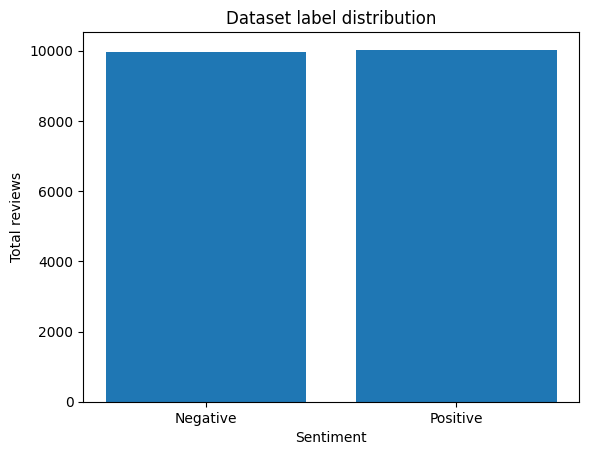

In [ ]:
plot_distribution(raw_train_ds)

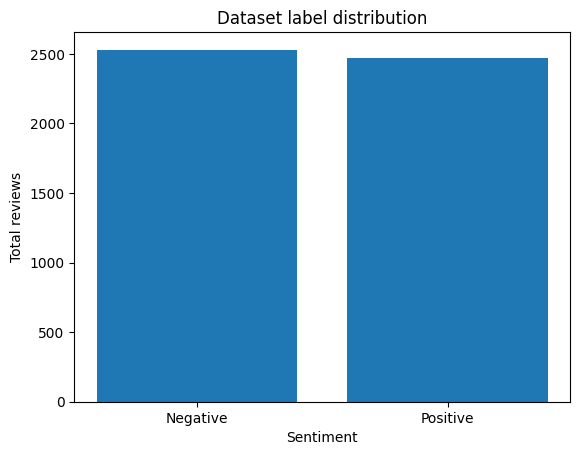

In [ ]:
plot_distribution(raw_val_ds)

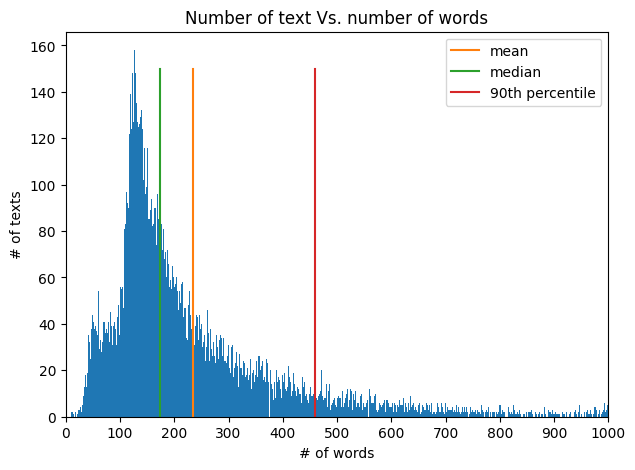

In [ ]:
plot_distribution_word(raw_train_ds)

The 2 different classes in the training and validation sets are correctly distributed. The model can be built on these data. The large majority of the texts in the training set are less than 500 words long. In the pre-processing step, texts are truncated to the 500th word.

### 2.3. Pre-processing layer

The textual data is pre-processed and converted before being used by the model. Three main phases are established:
- standardization (removes punctuation, all upper-case letters and unwanted characters)
- tokenization (transforms sentences into a series of tokens)
- vectorization (transforms tokens into integers)

The first phase is performed by the function `custom_standardization`.

In [ ]:
"""standardize texts"""
@keras.utils.register_keras_serializable()
def custom_standardization(input_text):
  no_uppercase = tf.strings.lower(input_text) # upper case --> lower case letters
  no_html_uppercase = tf.strings.regex_replace(no_uppercase, '<br />', ' ') # remove HTML strings
  no_punctuation_html_uppercase = tf.strings.regex_replace(no_html_uppercase, '[%s]' % escape(punctuation), '') # remove punctuation
  return no_punctuation_html_uppercase

The second and third phases uses the Keras API function `TextVectorization`. The 5,000 most frequently used words are listed in a dictionary and assigned to an integer. Tokens not referenced in the dictionary are assigned to the token `[UNK]`.

In [ ]:
vectorize_layer = keras.layers.TextVectorization(standardize=custom_standardization,
                                                 max_tokens=max_features,
                                                 output_sequence_length=max_length,
                                                 output_mode='int')

vectorize_layer.adapt(raw_train_ds.map(lambda x, y: x)) # dictionary creation with raw training texts (no label)

Transformations can be visualized using the following 2 functions. The first shows the text converted to an integer after pre-processing, while the second allows you to retrieve a token from an integer.

In [ ]:
"""show text-to-array transformation"""
def token_to_int(raw_text):
  raw_text = next(iter(raw_text))[0]
  print("Review before tokenization and vectorization: \n", raw_text[0].numpy())
  text_vectorized = tf.expand_dims(raw_text, -1) #
  text_vectorized = vectorize_layer(text_vectorized)
  print("\nReview after tokenization and vectorization: \n", text_vectorized[0].numpy())

In [ ]:
token_to_int(raw_train_ds)

Review before tokenization and vectorization: 
 b"I was one of the few non-liberals who showed up to see Steve's video. It was quite an experience... in propaganda film-making and boredom.<br /><br />I was hoping the film might be an actual documentary of Michael Moore's visit to my local school, UVSC, but it turned out to be another liberal, slash-and-burn effort to slam conservatives and the local religious community. It sure seems self-serving for a filmmaker to make a documentary that only reflects his preconceptions on issues.<br /><br />What's more surprising is to see all the '10' votes his homeys have posted here. Did they even see the video? Golly gee Batman, this must rank with All The President's Men! Their ratings are as obvious as the bias in this film. <br /><br />Yeah, like stacking the votes at IMDb will help a lame movie. Maybe my vote will help balance this out."

Review after tokenization and vectorization: 
 [  10   13   28    5    2  165    1   36 1152   57    6   

In [ ]:
"""give token from an index"""
def int_to_token(index):
  token = vectorize_layer.get_vocabulary()[index]
  print("The integer %d represents the token: %s" %(index, token))

In [ ]:
int_to_token(19)

The integer 19 represents the token: film


---


## **3. Model and training**


### 3.1. Dataset performances

*   `prefetch`: prefetch next batch while training. Avoid the risk of bottleneck (GPU Vs. I/O). The prefetch buffer size is automatically set via AUTOTUNE.
*   `cache`: dataset fits in RAM.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

raw_train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
raw_val_ds = raw_val_ds.cache().prefetch(buffer_size=AUTOTUNE)
raw_test_ds = raw_test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### 3.2. Neural network architecture & compilation

* Pre-processing layer `vectorize_layer`:
  * **Inputs:** strings of dimension `batch_size`
  * **Outputs:** an integer 2D tensor (`batch_size`, `max_length`)
  * **Comments:** if the number of string is less than `max_length`, the tensor is padded with zeros

* Embedding layer `Embedding`:
  * **Outputs:** a float 3D tensor (`batch_size`, `max_length`, `embedding_dim`)
  * **Comments:** each token is expressed as a float vector of dimension `embedding_dim`. All these vectors form a dictionary which is modified/adapted during the learning phase. Components of an embedding vector are considered as weights

* Pooling layer `GlobalAveragePooling1D`:
  * **Outputs:** a float 2D tensor (`batch_size`, `embedding_dim`)
  * **Comments:** average value of vector components

* Fully-connected layer `Dense`:
  * **Outputs:** a scalar between 0 ( = negative sentiment) and 1 ( = positive).
  * **Comments:** close to 0.5 = no clear opinion

The binary cross-entropy is used as loss function of the binary classification. With the sigmoid function applied to the model output, `BinaryCrossEntropy` is defined with `from_logits=False`.

In [ ]:
"""setup model"""
def create_model():
  embedding_dim = 16
  model = keras.Sequential([vectorize_layer, # pre-processing layer
                            keras.layers.Embedding(input_dim = max_features, output_dim = embedding_dim),
                            keras.layers.Dropout(0.2),
                            keras.layers.GlobalAveragePooling1D(),
                            keras.layers.Dropout(0.2),
                            keras.layers.Dense(1, activation='sigmoid')
                            ], name="classification_text_model")

  model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False),
                optimizer=keras.optimizers.Adam(learning_rate=0.001),
                metrics=[tf.metrics.BinaryAccuracy(name="binary_accuracy", threshold=0.5)])

  return model

### 3.3. Training phase


In [ ]:
"""training configuration"""
def train_model(model, training_data, validation_data, callbacks, **kwargs):
  kwargs.setdefault("epochs", 5)
  kwargs.setdefault("verbose", 2)
  log = model.fit(training_data, validation_data=validation_data, validation_freq=1, callbacks=callbacks, **kwargs)

  return log.history["loss"], log.history["binary_accuracy"], log.history["val_loss"], log.history["val_binary_accuracy"]

2 callbacks are defined and are used during the training phase:
*   `stop_early`: stop training when a `val_binary_accuracy` has stopped improving.
*   `cp_callback`: save the model when `val_binary_accuracy` is maximum.




In [ ]:
callbacks = [keras.callbacks.EarlyStopping(monitor='val_binary_accuracy',
                                           patience=5,
                                           restore_best_weights=True,
                                           min_delta=0.001),
             keras.callbacks.ModelCheckpoint(filepath='02_classification_text.keras',
                                          monitor = "val_binary_accuracy",
                                          save_best_only = True,
                                          mode = "max",
                                          save_weights_only=False,
                                          verbose=0)]

In [ ]:
if device == "GPU":
  model = create_model()
  classifier_accuracy = train_model(model, raw_train_ds, raw_val_ds, callbacks, epochs=epochs)
  print("Accuracy max %0.1f %% reached at the epoch %d" %(100*max(classifier_accuracy[3]), np.argmax(classifier_accuracy[3])+1))

Cloning into 'TensorFlow_duplicata'...
remote: Enumerating objects: 834, done.
remote: Counting objects: 100% (251/251), done.
remote: Compressing objects: 100% (155/155), done.
remote: Total 834 (delta 188), reused 96 (delta 96), pack-reused 583 (from 2)
Receiving objects: 100% (834/834), 190.98 MiB | 28.67 MiB/s, done.
Resolving deltas: 100% (419/419), done.


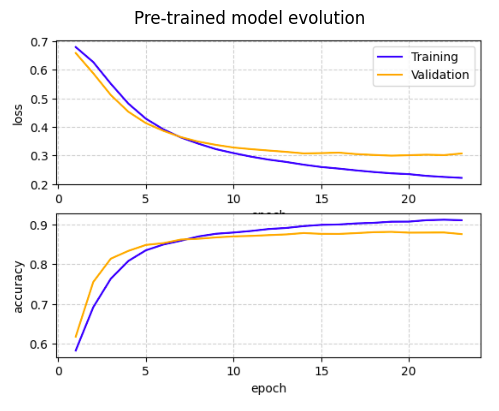

In [ ]:
if device == 'GPU':
  plot_evolution(classifier_accuracy)
else:
  training_curves, model = get_github_files() # get the pre-trained model and training curves
  plt.imshow(training_curves), plt.title("Pre-trained model evolution"), plt.axis("off")

The precision/loss of the 2 sets evolve conjointly. The callback `stop_early` stopped the training when `val_binary_accuracy` has been stabilized since 18 epochs.

---


## **4. Evaluation and limitations**


### 4.1. Evaluation

In [ ]:
"""evaluate and make predictions"""
def get_predictions(model, dataset):
  loss_test, accuracy_test = model.evaluate(dataset, verbose=0)
  predictions = model.predict(dataset, verbose=0)
  print("Test loss value: %0.1f \nTest accuracy: %0.1f %%" %(loss_test, 100*accuracy_test))
  return predictions

In [ ]:
predictions = get_predictions(model, raw_test_ds)

Test loss value: 0.3 
Test accuracy: 88.4 %


############################
Evaluation on the test set: 
############################
Accuracy...0.8839
Recall.....0.8958
F1-score...0.8853


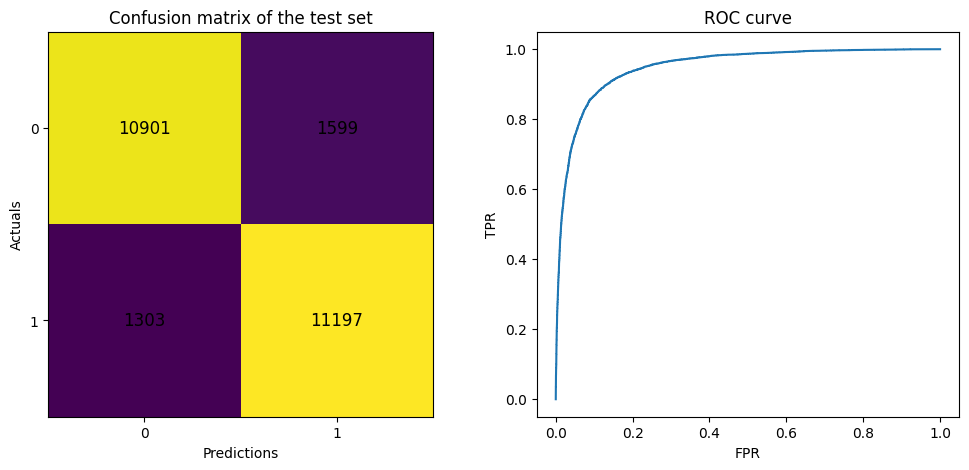

In [ ]:
plot_evaluation(raw_test_ds, predictions)

The confusion matrix effectively confirms the very good accuracy rate obtained by the classifier. The diagonal coefficients are much higher than the extra-diagonal coefficients. The ROC curve corresponds to that of an ideal classifier with an area under the curve close to 1.

The metric `recall` measures the proportion of true positives (here 11259) among all truly positive elements (here 11259+1241). With a recall equals to 90%, the model misses almost no positive reviews

The F1-score of 88% indicates that the model strikes a good balance between the ability to detect positives without generating too many false positives.

### 4.2. Predictions

The model can be used to recognize the sentiment of new/fictitious movie review. Be free to write your own review in English!


In [ ]:
"""return a predicted score from the classifier"""
def give_sentiment(review):
  review = tf.constant(review)

  prediction = model.predict(review, verbose=0)
  if prediction < 0.5:
    print("The movie looks pretty bad. (score model: ", round(prediction[0][0], 1), ")")
  else:
    print("Great movie, go see it in the cinema! (score model: ", round(prediction[0][0], 1), ")")

In [ ]:
my_review = ["This movie was terrible and boring. Most of scenes were violents and useless."]

give_sentiment(my_review)

The movie looks pretty bad. (score model:  0.2 )


### 4.3. Error analysis

Next, the model's prediction errors are analyzed to determine the model's limits.

The distribution of the 25,000 predictions shows that the model tends to answer in a binary way and with little hesitation. Around 75% of test texts have a predicted score below 0.3 (bad/terrible movie) or above 0.7 (correct/great movie).

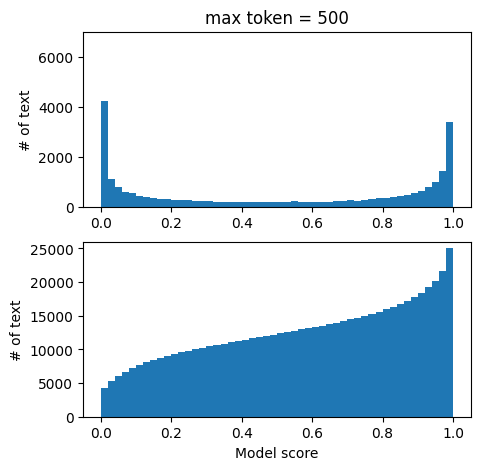

In [ ]:
plot_predicted_score(predictions, max_length)

Two additional training runs were completed for different maximum word counts per review: `max_length = 250` and `max_length = 2000`. It seems that the more words the reviews have, the less binary and extreme the model's predictions will be. However, a lack of improvement in the accuracy of model predictions on the test set is observed for `max_length = 2000` (88.5%) and `max_length = 500` (88.5% too). The test accuracy for `max_length = 100` is equal to  86.4%.

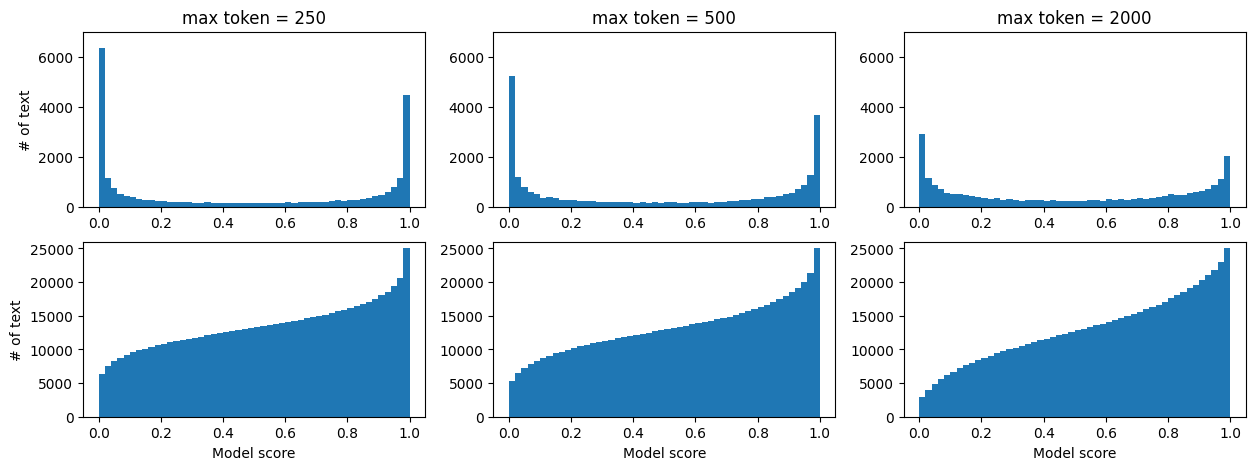

The error rate of model's predictions is analyzed according to the word count, to see whether the quantity of words has an impact on predictions.

In [ ]:
"""plot the error proportion Vs. the number of words containing in a review"""
def compute_error(raw_test_ds, predictions):
  labels = []
  texts = []
  nb_word = []

  for text, label in raw_test_ds.take(int(tf.data.experimental.cardinality(raw_test_ds))):
      for i in range(len(text)):
          labels.append(label.numpy()[i])
          texts.append(text.numpy()[i])
          nb_word.append(len(text.numpy()[i].split())) # count the number of words

  errors = (np.round(predictions[:,0], 0) - np.array(labels) != 0) # truncate scores to obtain either 0 or 1
  y_prediction_error = predictions[errors] # get wrong labels
  y_test_error = np.array(labels)[errors] # get actual labels
  nb_word_error = np.array(nb_word)[errors]

  unique_elements_test, counts_elements_test = np.unique(nb_word, return_counts=True)
  unique_elements_error, counts_elements_error = np.unique(nb_word_error, return_counts=True)

  mask = np.isin(unique_elements_test, unique_elements_error)
  ratio = counts_elements_error/counts_elements_test[mask]

  plot = plot_error_rate(unique_elements_error, ratio, max_length)

  return texts, errors, y_test_error, y_prediction_error, plot

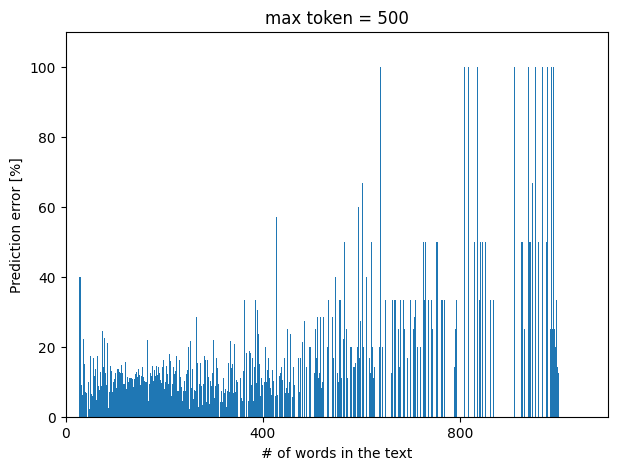

In [ ]:
texts, errors, y_test_error, y_prediction_error, plot = compute_error(raw_test_ds, predictions)

Mispredicted texts and labels are collected and expressed according to the number of words contained in the review. For `max_length = 500`, less than 20% of short and medium-length reviews are incorrectly predicted. Same conclusion for `max_length = 250` and `max_length = 2000`. Several reasons can be given:
*   there are very few long reviews, so one bad prediction is more serious for a set of 1/2 long texts than for a dozen short ones.
*   long reviews are generally written by film experts, using a richer vocabulary and therefore less present in the model dictionary.  
*   parameter `max_length` has a significant impact on predictions. The higher the number of words retained, the less error the model will make for long texts. However, the accuracy of the test set remains unchanged.


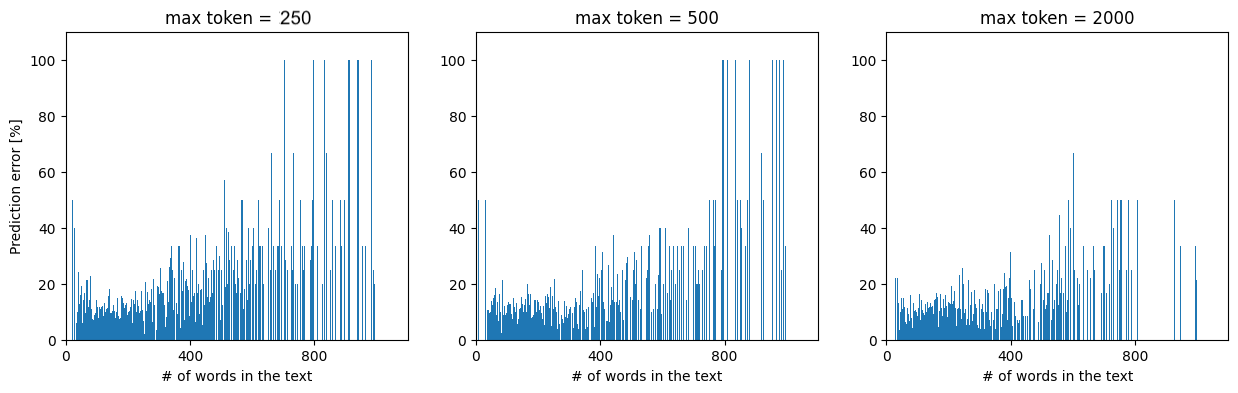

Finally, in analyzing the poorly predicted texts, it would seem that lack of context and attention would cause mispredictions. Example with a text misinterpreted by the model:

```markdown
"Complete entertainment! Although there are many strange things in the movie that the fairy tale itself doesn't have them including the autumn characters (mother and daughter), the general concept rocks."
```

The true label is positive, while the model predicts a negative review. A negative comment was inserted into this positive review without affecting the general author's opinion. A lack of context and model attention produced this misclassification.



In [ ]:
i = 100
x_test_error = np.array(texts)[errors] # get actual labels
true_label, predicted_label = y_test_error[i], y_prediction_error[i,0]
print("True label: %0.0f" %true_label)
print("Predicted label: %0.0f" %predicted_label)
x_test_error[i]

True label: 1
Predicted label: 0


b"'Don't Look In the Basement' is so easy to knock but the truth is simply that Brownrigg is one of Horrors real underground stars and IMHO is vastly overdue some proper recognition. 'Don't' is his undisputed masterpiece. This scummy psychodrama snags the viewer straightaway into such an odd, disjointed, claustrophobic world of sweating insanity you have no real idea what the hell is going on. It succeeds in making you feel strangely dirty, just plain grubby, for Brownrigg's world is this mad, unwashed, scummy prison cell of rants, obsessions and all shades of mental illness. And he uses his low budget palette to wrap his grot blanket around you like a bad memory. There is just something so beautifully odd about the whole damn thing. In a word, classic.... Also, if you watch 'Don't' first then you will have some idea of the insane psychodrama style that marks Brownrigg's other films. In summary they really don't come any more esoteric than this - well, actually they do, track down Brow

---


## **5. Go further: the embedding dictionary**


### 5.1. Embedding dictionary creation

The weights of the embedding layer (= the embedding vectors) are extracted and added to a dictionary with their definition (= the associated word).

In [ ]:
"""generate a dictionary and refer tokens to their vector"""
def build_embedding_dict(model):
  embeddings_vector = model.layers[1].get_weights()[0] # get the 5,000 vectors of the embedding layer
  vocab = vectorize_layer.get_vocabulary()
  dictionary = {vocab[i]:embeddings_vector[i] for i in range(max_features)}
  print("Dictionary shape: ", np.shape(embeddings_vector))

  with open('02_classification_text_dict.json', 'w') as f: # save dictionary in JSON format
    modified_dict = {k: v.tolist() for k, v in dictionary.items()}
    json.dump(modified_dict, f)

  return dictionary, vocab

In [ ]:
my_dict, all_words = build_embedding_dict(model)

Dictionary shape:  (5000, 16)


The embedding dictionary can be visualized as a 16-dimensional space where each of the 5,000 words is an element of this space. For example, the word "good" corresponds to:

In [ ]:
my_dict["good"]

array([-0.8861961 ,  1.0262399 , -1.1325543 , -1.0803169 ,  0.96303165,
       -0.9292819 ,  1.0537893 ,  0.9079898 ,  0.90297556, -0.9672598 ,
        0.831316  , -0.9564878 , -0.8567917 ,  1.0512615 ,  0.75058097,
        1.0785363 ], dtype=float32)

Embedding projector software (https://projector.tensorflow.org/?hl=fr) provides a comprehensive representation of this space using the PCA dimension reduction method. The images below are taken from this software.

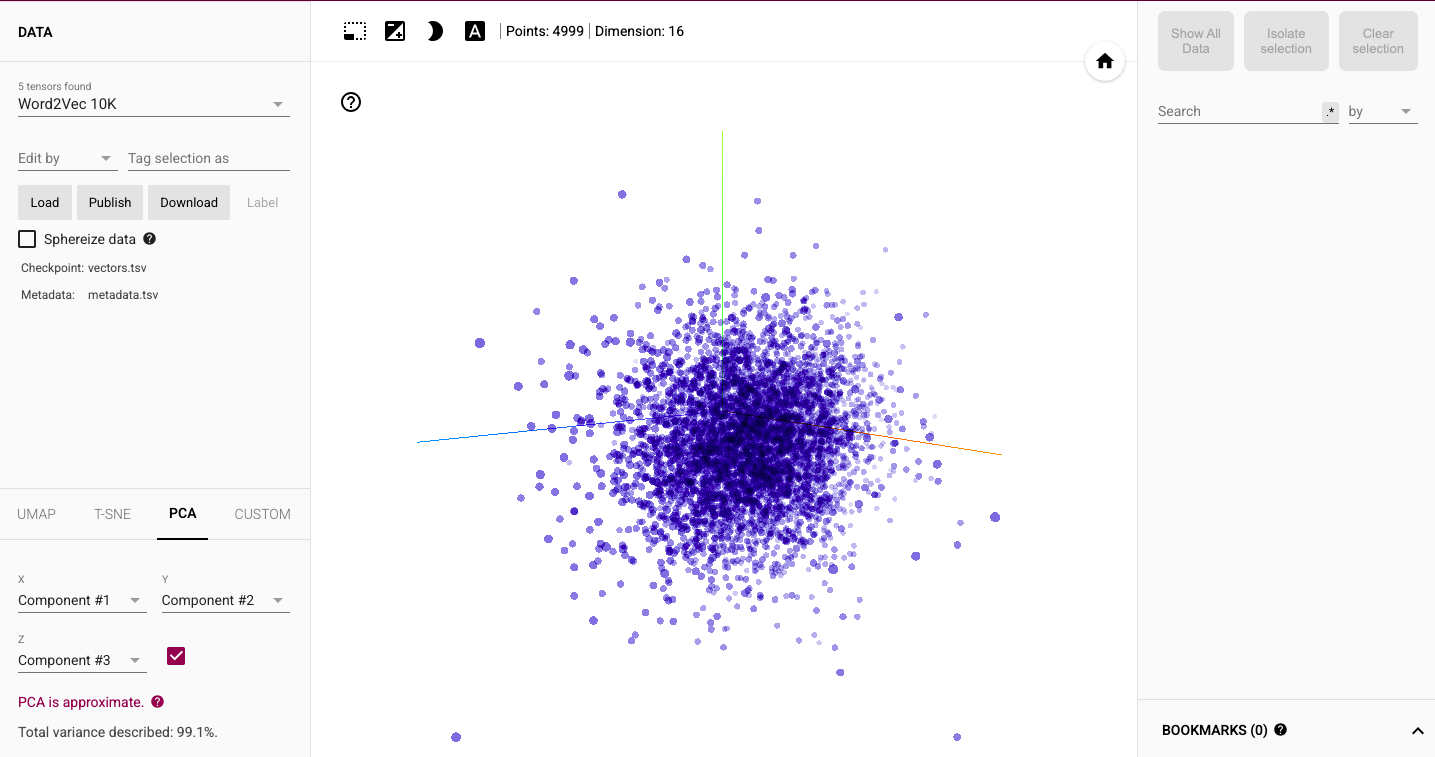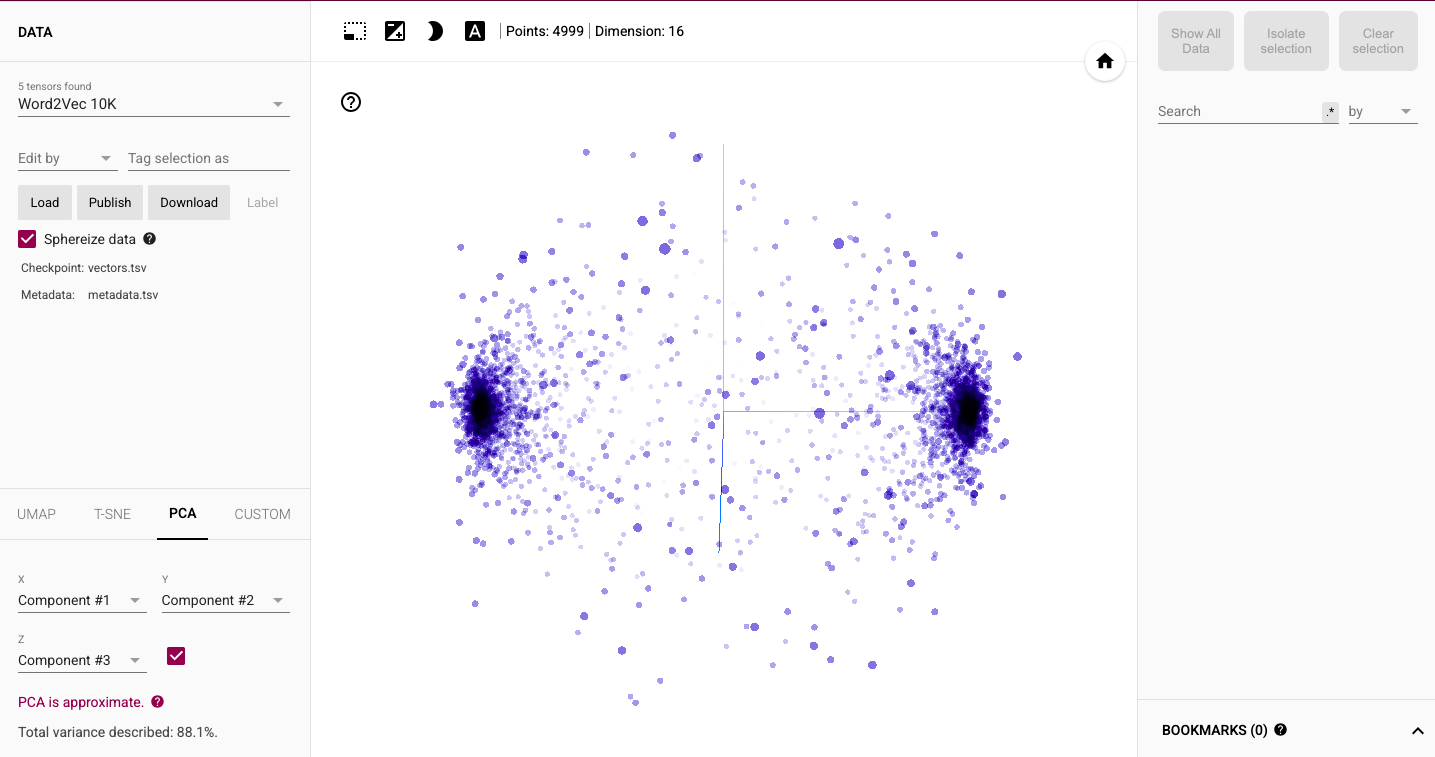

By applying a spherical transformation, 2 word clusters are created: words expressing positive and negative feelings.

### 5.2. Distance and similarity

A notion of distance can be introduced in the embedding space
[[4]](https://www.cs.toronto.edu/~lczhang/360/lec/w05/w2v.html) and therefore, two words are "close" to each other in the embedding space if the distance between them is low.

A second and reliable quantity to measure similarity is the cosinus similarity. Two vectors have a cosine similarity of 1, two orthogonal and independant vectors have a similarity of 0, and two opposite vectors have a similarity of -1.

In [ ]:
"""get the distance between two elements in the embedding space"""
def get_distance(token1, token2):
  p1 = my_dict[token1]
  p2 = my_dict[token2]
  distance = np.linalg.norm(p2-p1)
  return distance

"""get the cosinus similarity between two elements in the embedding space"""
def get_cosinus_similarity(token1, token2):
  p1 = my_dict[token1]
  p2 = my_dict[token2]
  dot_product = np.dot(p1, p2)
  magnitude_1 = np.linalg.norm(p1)
  magnitude_2 = np.linalg.norm(p2)
  cosine_sim = dot_product / (magnitude_1 * magnitude_2)
  return cosine_sim

In [ ]:
get_distance("good", "terrible")

20.08827

In [ ]:
get_cosinus_similarity("good", "terrible")

-0.9951986

In [ ]:
get_distance("disappointing", "terrible")

4.372044

In [ ]:
get_cosinus_similarity("disappointing", "terrible")

0.99945146

With the notion of distance and cosinus similarity, it's possible to explore the entire embedding dictionary to find the words closest to a specific word.

In [ ]:
"""get neighbors for a given token"""
def get_synomym(token, n=10, used_distance=True): # get elements closest to a specific element in the embedding space
  p1 = my_dict[token]
  candidate_list = {} # stores n synonyms
  for i in range(1, max_features): # only the first 1000 words of the embedding dictionary are searched
    token_candidate = all_words[i]
    if used_distance == True: candidate_list[token_candidate] = get_distance(token, token_candidate)
    else: candidate_list[token_candidate] = get_cosinus_similarity(token, token_candidate)

  sorted_items = sorted(candidate_list.items(), key=lambda item: item[1])

  if used_distance == True: synonym_list = sorted_items[1:n+1]
  else: synonym_list = sorted_items[-(n+1):-1]
  words = [(item[0], item[1]) for item in synonym_list]
  return print(words)

In [ ]:
get_synomym("terrible", used_distance=False)

[('absurd', 0.9996941), ('unconvincing', 0.9996959), ('uninspired', 0.99969894), ('210', 0.9997312), ('disappointment', 0.99973124), ('waste', 0.9997362), ('tedious', 0.999751), ('worst', 0.99978125), ('badly', 0.9997878), ('mess', 0.999879)]


When comparing with Embedding projector, some words are in common and others are not, because in the function `get_synonym`, only the first 1000 words in the dictionary are searched.

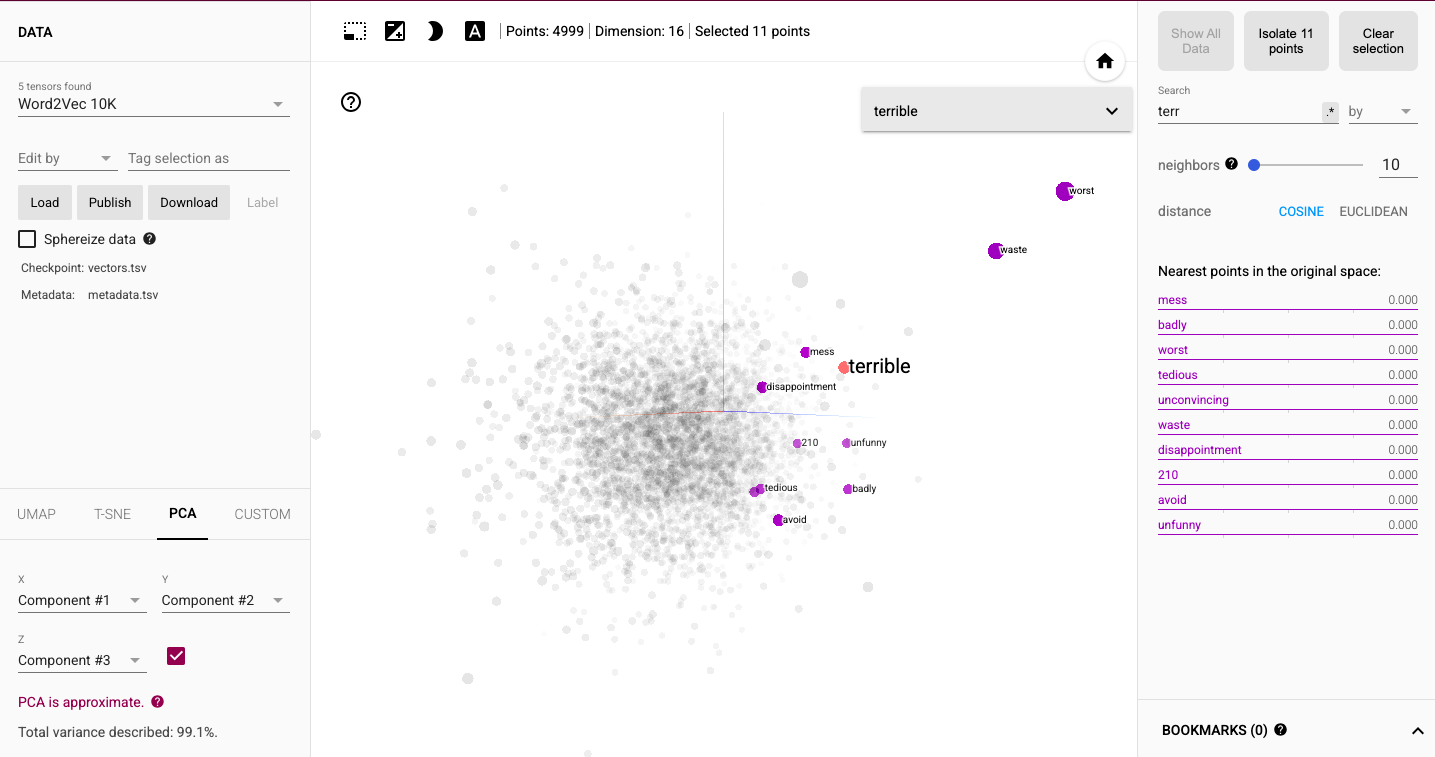

Finally, analogies between words can be tested.

In [ ]:
"""get tokens found with an analogy"""
def get_analogy(vector, n):
  candidate_list = {} # stores n synonyms
  for i in range(1, max_features):
    token_candidate = all_words[i]
    vector_candidate = my_dict[token_candidate]
    candidate_list[token_candidate] = sum(abs(vector - vector_candidate))

  sorted_items = sorted(candidate_list.items(), key=lambda item: item[1])
  synonym_list = sorted_items[0:n]
  words = [item[0] for item in synonym_list]
  print(words)

In [ ]:
analogy = my_dict["funny"] - my_dict["nice"] + my_dict["terrible"]
get_analogy(analogy, 5)

['waste', 'awful', 'worst', 'poorly', 'boring']


---


## **6. Limitations and conclusion**

The richness of the dictionary is adequate for a simple positive/negative classification model, but remains limited when exploring the embeddings space.  Some of the words proposed are not really synomyms, opposites or good analogies. To complete the dictionary, it's necessary to train the model with new collections of texts, different from the cinema theme, to introduce new words.

With over 88% accuracy, the text classification model is quiet reliable. It's able to capture the author's feeling with an review. However, the model has limitations for long texts and those requiring context. Thus, attention mechanism would help to achieve higher levels of precision



---


## **7. References**


| | | | | |
|------|------|------|------|------|
| Index | Title | Author(s) | Type | Comments |
|[[1]](https://aclanthology.org/P11-1015.pdf) | IMDB dataset | Andrew L. Maas & al | dataset & paper | - |
|[[2]](https://www.tensorflow.org/tutorials/keras/text_classification) | Basic text classification | TensorFlow | dataset | - |
|[[3]](https://www.tensorflow.org/guide/data_performance) | Better performance with the tf.data API | TensorFlow | Tutoriels | - |
|[[4]](https://www.cs.toronto.edu/~lczhang/360/lec/w05/w2v.html) | Word2Vec and GloVe Vectors | Toronto university | website | - |

In [ ]:
print("Notebook run in %.1f seconds on %s" % ((time() - start), tf.config.list_physical_devices(device_type=None)[-1][-1]))

Notebook run in 85.7 seconds on CPU
